### OD = log_10(I_0 / I) where I_0 is the intensity of the light through the blank and I is the intensity through the sample. 
OD600 for general bacterial cultures, 
OD750 for cyanobacteria

The green LED/photo diode is the closest to 600 nm. Green LEDs typically peak around 520-570 nm, which is the closest to 600 nm among the available options.
OD750 Measurement:
The red LED/photo diode is the closest to 750 nm. Red LEDs typically peak around 620-750 nm. While not perfect, the red LED is the best available option for approximating measurements near 750 nm.


In [44]:
from IPython.display import clear_output
# import plotly.graph_objects as go

# def live_plot_with_plotly(df, cols=['RED OD (550-650nm)', 'BLUE OD (400-500nm)', 'GREEN OD (475-600nm)', 'CLEAR OD (400-650nm)'], y_label='Optical Density', figsize=(10, 6), title=''):
#     clear_output(wait=True)
    
#     fig = go.Figure()
    
#     fig.add_trace(go.Scatter(x=df['time'], y=df[cols[0]], mode='lines', name=cols[0], line=dict(color='red')))
#     fig.add_trace(go.Scatter(x=df['time'], y=df[cols[1]], mode='lines', name=cols[1], line=dict(color='blue')))
#     fig.add_trace(go.Scatter(x=df['time'], y=df[cols[2]], mode='lines', name=cols[2], line=dict(color='green')))
#     fig.add_trace(go.Scatter(x=df['time'], y=df[cols[3]], mode='lines', name=cols[3], line=dict(color='black', dash='dash')))
    
#     fig.update_layout(
#         title=title,
#         xaxis_title='Time (s)',
#         yaxis_title=y_label,
#         legend_title='Colors',
#         template='plotly_white',
#         autosize=False,
#         width=figsize[0] * 100,  # Convert inches to pixels for width
#         height=figsize[1] * 100,  # Convert inches to pixels for height
#     )
    
#     fig.show()
from matplotlib import pyplot as plt
import seaborn as sns

def live_plot(df, cols=['RED OD (550-650nm)', 'BLUE OD (400-500nm)', 'GREEN OD (475-600nm)', 'CLEAR OD (400-650nm)'], y_label='Intensity', figsize=(10, 6), title=''):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    sns.lineplot(x='time', y=cols[0], data=df, label=cols[0], color='red')
    sns.lineplot(x='time', y=cols[1], data=df, label=cols[1], color='blue')
    sns.lineplot(x='time', y=cols[2], data=df, label=cols[2], color='green')
    sns.lineplot(x='time', y=cols[3], data=df, label=cols[3], color='black', linestyle='--')
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Time (s)')
    plt.ylabel(y_label)
    plt.legend(loc='upper left')
    plt.show()

In [45]:
from IPython.display import clear_output
import numpy as np
import pandas as pd
import time
from tinkerforge.ip_connection import IPConnection, Error
from tinkerforge.bricklet_color_v2 import BrickletColorV2
from tinkerforge.bricklet_silent_stepper_v2 import BrickletSilentStepperV2

%matplotlib inline

HOST = "localhost"
PORT = 4223
CB1_UID = "2733"  
CB2_UID = "2736" 
SS1_UID = "26Mt"
SS2_UID = "26Mo"

# Create IP connection
ipcon = IPConnection()

# Create device objects
cb1 = BrickletColorV2(CB1_UID, ipcon)
cb2 = BrickletColorV2(CB2_UID, ipcon)
ss1 = BrickletSilentStepperV2(SS1_UID, ipcon)
ss2 = BrickletSilentStepperV2(SS2_UID, ipcon)

SS_SPEED = 150

try:
    ipcon.connect(HOST, PORT)
    print("Connected to brickd")
except Error as e:
    print(f"Error connecting to brickd: {e}")


Connected to brickd


In [46]:
# Setting gain to 16x rather than 60x
cb1.set_configuration(1, 3)
cb2.set_configuration(1, 3)

def initialize_motor(ss):
    # 416 mA, for 10W 24V system
    ss.set_motor_current(416) 
    # 1/8 steps (interpolated)
    ss.set_step_configuration(ss1.STEP_RESOLUTION_8, True) 
    ss.set_max_velocity(SS_SPEED) 
    ss.set_speed_ramping(SS_SPEED, SS_SPEED)
    ss.set_enabled(True) 

def set_light(bricklet, enable):
    bricklet.set_light(enable)

In [47]:
# These baselines were calculated separately
RED_INTENSITY_0 = 12892.648557
BLUE_INTENSITY_0 = 10718.940577
GREEN_INTENSITY_0 = 6866.996604
CLEAR_INTENSITY_0 = 26856.404075

def retrieve_OD(df, start_time):
    set_light(cb1, True)
    set_light(cb2, False)
    red, blue, green, clear = cb2.get_color()
    red_od, blue_od, green_od, clear_od = np.log10(RED_INTENSITY_0 / red), np.log10(BLUE_INTENSITY_0 / blue), np.log10(GREEN_INTENSITY_0 / green), np.log10(CLEAR_INTENSITY_0 / clear)
    current_time = time.time() - start_time
    df.loc[len(df)] = [current_time, red, blue, green, clear, red_od, blue_od, green_od, clear_od]
    # preserve the light by turning it off again
    set_light(cb1, False) 
    set_light(cb2, False)
    return df

In [48]:
def start_experiment(output_name, duration=14 * 24 * 60 * 60, interval=60):
    df = pd.DataFrame(columns=['time', 'red', 'blue', 'green', 'clear',  'RED OD (550-650nm)', 'BLUE OD (400-500nm)', 'GREEN OD (475-600nm)', 'CLEAR OD (400-650nm)'])
    start_time = time.time()

    initialize_motor(ss1)
    initialize_motor(ss2)
    ss1.drive_backward()
    ss2.drive_forward()

    while time.time() - start_time < duration:
        df = retrieve_OD(df, start_time)
        df.to_csv(output_name)
        live_plot(df)
        time.sleep(interval)
    return df

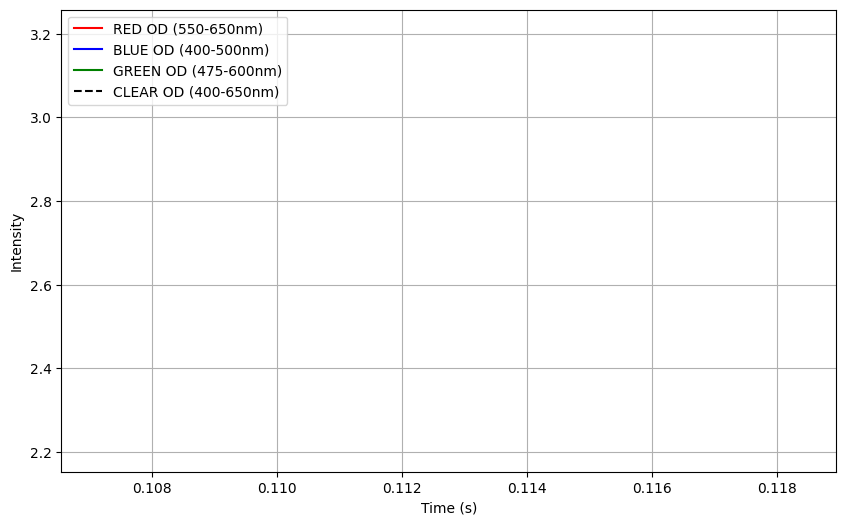

In [49]:
intensities_df = start_experiment('07.29.24_v2_misting_experiment.csv')

In [ ]:
# Disconnect from brickd
ipcon.disconnect()
